In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [37]:
np.random.seed(0)

# Project Settings
## basic setting
asset price process follows BS model with $\mu=0.1, \sigma=0.25$
current spot price is 10 dollars
strike price is 10 dollars (option at the money)
transaction cost: 0.005 dollar per share, 0.005 dollar per option
only trade Integer number of shares and options
risk-free rate 5% per year

## Our position:
just sold 10_000 units of call at the money with 63 days to maturity (call this option g)
allow holding stock, bank account and another call option strike=10, maturity = 0.3 year (75.6 days) (call this option h)
Hedge frequency: 4 times per day

## Question 1
simulate 5000 paths, compare delta hedge and delta-gamma hedge pnl, how do they vary as $\mu$ varies ?

## Question 2
choose two sample path: one ends up in-the-money, one ends up out-of-money:
plot the hedging position of delta hedge and delta-gamma hedge, compare the two methods (transaction cost included)

## Question 3
suppose real-world P volatility is $\sigma \in ${20%,22%,...,30%} but you still sold the option and hedge using $\sigma=0.2$, compare again delta hedge and delta-gamma hedge


# Question 1

In [38]:
Ntrials = 5000
spot_price = 10
mu = 0.1
sigma = 0.25
num_of_call_option_sold = 10_000

In [39]:
# our stock path should be GBM under BS-model settings. and since our hedge frequency is 4, we need to simulate 63*4 time steps with quater day mu and sigma
def quarter_day_stock_path_GBM(annual_mu,annual_sigma,num_of_days):
    quater_day_mu = annual_mu/252/4
    quater_day_sigma = annual_sigma/np.sqrt(252*4)
    res=np.empty((Ntrials,num_of_days*4))
    res[:,0]=spot_price
    for i in range(1,num_of_days*4):
        res[:,i]=res[:,i-1]*np.exp(quater_day_mu+quater_day_sigma*np.random.normal(0,1,Ntrials))
    return res

In [40]:
stock_path = quarter_day_stock_path_GBM(mu,sigma,63)

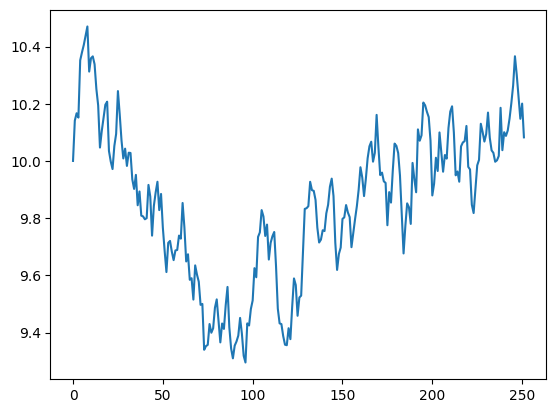

In [41]:
plt.plot(stock_path[0,:])

In [47]:
def call_option_BS(stock_path:np.ndarray,strike:float,risk_free_rate:float,maturity_days:int,calculation_day_length:int,sigma:float):
    """
    calculate quarter-day call option price using BS model
    :param sigma: 
    :param stock_path: (Ntrials , num_of_days*4) 
    :param strike: float
    :param risk_free_rate: float
    :param maturity_days: int, how many days left to maturity
    :param calculation_day_length:int, how many days you want to calculate the price 
    :param mu: float, annual mu
    :param sigma: float, annual sigma
    :return: ndarray of (Ntrials,length_days*4), tuple of three: call option price, delta, gamma
    """
    quater_day_risk_free_rate = risk_free_rate/252/4
    quater_day_maturity = maturity_days*4
    quarter_day_calculation_length = calculation_day_length*4
    quarter_day_sigma = sigma/np.sqrt(252*4)
    quarter_day_time_to_maturity=np.arange(0,maturity_days,1/4)[::-1][0:quarter_day_calculation_length]
    d1 = (np.log(stock_path[:,0:calculation_day_length*4]/strike)+(quater_day_risk_free_rate+quarter_day_sigma**2/2)*quarter_day_time_to_maturity)/(quarter_day_sigma*np.sqrt(quarter_day_time_to_maturity))
    d2 = d1 - quarter_day_sigma*np.sqrt(quarter_day_time_to_maturity)
    option_gamma= stats.norm.pdf(d1)/(stock_path[:,0:calculation_day_length*4]*quarter_day_sigma*np.sqrt(quarter_day_time_to_maturity))
    return stock_path[:,0:calculation_day_length*4]*stats.norm.cdf(d1)-strike*np.exp(-quater_day_risk_free_rate*quarter_day_time_to_maturity)*stats.norm.cdf(d2),stats.norm.cdf(d1),option_gamma

In [48]:
call_option_price,call_option_delta,call_option_gamma = call_option_BS(stock_path,10,0.05,63,63,sigma)

C:\Users\kevin\AppData\Local\Temp\ipykernel_11712\3648860839.py:19: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(stock_path[:,0:calculation_day_length*4]/strike)+(quater_day_risk_free_rate+quarter_day_sigma**2/2)*quarter_day_time_to_maturity)/(quarter_day_sigma*np.sqrt(quarter_day_time_to_maturity))
C:\Users\kevin\AppData\Local\Temp\ipykernel_11712\3648860839.py:21: RuntimeWarning: invalid value encountered in divide
  option_gamma= stats.norm.pdf(d1)/(stock_path[:,0:calculation_day_length*4]*quarter_day_sigma*np.sqrt(quarter_day_time_to_maturity))


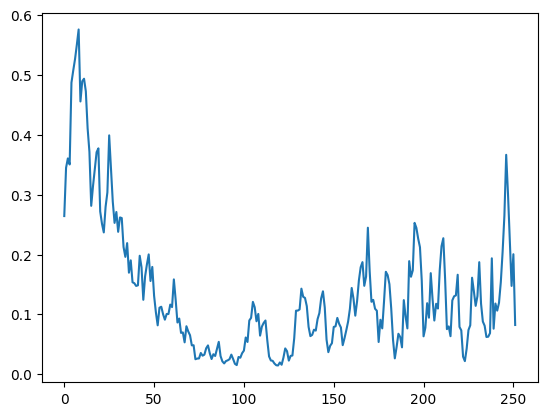

In [49]:
plt.plot(call_option_price[0,:])

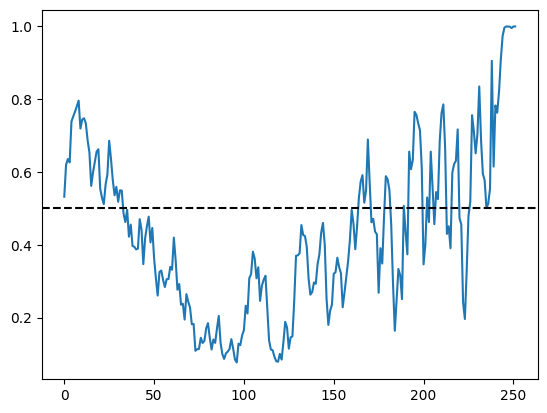

In [53]:
plt.plot(call_option_delta[0,:])

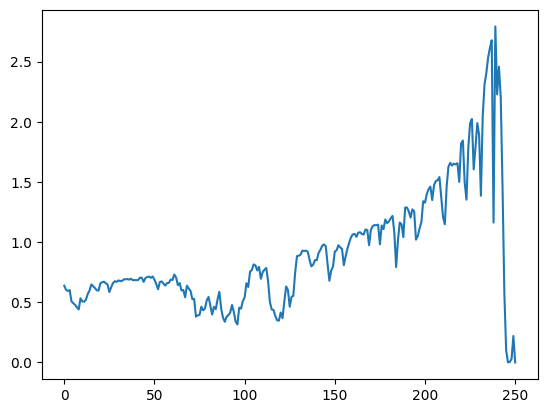

In [51]:
plt.plot(call_option_gamma[0,:])

In [ ]:
def delta_hedge_position(portfolio_delta,stock_path,):
    """
    :param portfolio_delta: (Ntrials,length_days*4)
    :param stock_path: (Ntrials,length_days*4)
    :return: alpha: short position in stock, 
    B: long position in bank account to make our portfolio self-financing (Ntrials,length_days*4) 
    """
    alpha = -portfolio_delta
    
    return 